# Model prediction and post-processing for a test area

## Background

The trained machine learning classifier can now be applied to create a crop type map. Since our goal is to produce a map that can be visualized as well as used to generate statistics, it is important to check the model's ability to produce a spatial map that makes sense to users.

When training the model, we have not considered the spatial locations of data. For each pixel on the ground, the model will be applied independently. This means neighbouring pixels within the same crop field may be predicted to have different crop types due to inherent noise. The resulting “salt-and-pepper” effect may impact the visual interpretation of a map. This effect can be reduced through spatial filtering. 

It is also important to note that we only trained the model to recognize different type of crops, not non-crop land covers. When the model is applied to all pixels in an image, the predictions over non-crop areas are not meaningful. We have chosen this approach to focus on distinguishing between different crop types and we use the [DE Africa Cropland Extent Service](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) to contrain the analysis to cropped area. The accuracy of the crop type map extent is therefore limited by the accuracy of the cropland extent map which is created for 2019.

An alternative approach is to map the crop types together with other types of land cover. This is a much more complex task since the model needs to be trained with data that captures the diversity of many distinct land covers.

## Description

This notebook applies the classifier trained in the [fit classifier notebook](3_Fit_classifier.ipynb) to a test area and demonstrates how to filter it with the [DE Africa Cropland Extent Service](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) and visualize the results.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline

import xarray as xr
from joblib import load
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import pickle

import datacube
from datacube.utils.cog import write_cog
from odc.io.cgroups import get_cpu_quota

from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.plotting import display_map
from deafrica_tools.classification import predict_xr
    
from feature_collection import feature_layers

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

## Create Dask cluster for running predictions

We use dask to parallel and speed up the processing.

In [2]:
ncpus = round(get_cpu_quota())
print("ncpus = " + str(ncpus))

client = create_local_dask_cluster(return_client=True, n_workers=1, threads_per_worker=ncpus)

ncpus = 15


Client Scheduler: tcp://127.0.0.1:33373 Dashboard: /user/fang.yuan@digitalearthafrica.org/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Load model and class labels

We use the model trained and saved in the [fit classifier notebook](3_Fit_classifier.ipynb). it is important that the list of features used match the model.

In [3]:
model_basepath = "Results/Model"

# Choose model and load
model_path = os.path.join(model_basepath, "rf_removecorrfeaturesgt0p9_simplified_cv.joblib")
model = load(model_path).set_params(n_jobs=1)


# Get label dictionary
labels_path = os.path.join(model_basepath, "class_labels.json")
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

# Get model features
feautres_path = os.path.join(model_basepath, "rf_removecorrfeaturesgt0p9_simplified_features.json")
with open(feautres_path, "r") as json_file:
    features_dict = json.load(json_file)
    
features = features_dict["features"]

In [4]:
len(features)

46

## Define test location

Define the latitude and longitude range for the test location and check the location on a map.

In [5]:
lon_range =(33.9, 33.95)
lat_range = (-18.63, -18.58)

In [6]:
display_map(lon_range, lat_range)

## Create the query for running the predictions

We use the query saved from the training data collection notebook to ensure data from the same periods are retrieved. However, only selected features will be used. 

> We add `dask_chunks` to the query parameter so the data will be lazy-loaded and only the features used by the model will be calculated.

In [7]:
# Load the query used for fitting
query_file = os.path.join(model_basepath, "query.pickle") 

with open(query_file, "rb") as f:
    query = pickle.load(f)
    
# Specify any specific additions to the data query -- e.g. dask_chunks for enabling parallel computation
dask_chunks = {"x": 1500, "y": 1500}
query.update({"dask_chunks": dask_chunks})

query

{'semiannual_geomad_times': {'semiannual_2021_07': '2021-07-01',
  'semiannual_2022_01': '2022-01-01'},
 'monthly_ndvi_time_range': ('2021-10', '2022-09'),
 'ls_fc_cover_times': {'Q4_2021': slice('2021-10-01', '2021-12-31', None),
  'Q1_2022': slice('2022-01-01', '2022-03-31', None),
  'Q2_2022': slice('2022-04-01', '2022-06-30', None),
  'Q3_2022': slice('2022-07-01', '2022-09-30', None)},
 'resolution': (-10, 10),
 'output_crs': 'EPSG:6933',
 'dask_chunks': {'x': 1500, 'y': 1500}}

## Apply model to the test area

The model will be applied, producing a prediction map and a probabilities map.

In [8]:
%%time

dc = datacube.Datacube()

query.update({"lat": lat_range, "lon": lon_range})

# calculate features
data = feature_layers(query)

# Only keep features that are in the original list of columns
data = data[features]

# predict using the imported model
predicted = predict_xr(
    model, data, proba=True, persist=True, clean=True, return_input=True
).persist()

predicting...
   probabilities...
   input features...
CPU times: user 8.72 s, sys: 5.2 s, total: 13.9 s
Wall time: 18.5 s


### Mask with Cropland Extent

[DE Africa's Cropland Extent Service](https://docs.digitalearthafrica.org/en/latest/data_specs/Cropland_extent_specs.html) is accessed and used to constrain the cropped locations. Predictions outside the cropped area are set to Nan.

In [9]:
# Load masks and clip
crop_mask_query = {'resolution': query['resolution'],
                   'output_crs': query['output_crs'],
                   'lat': query['lat'],
                   'lon': query['lon']}

# Load the crop mask
print("    Loading crop_mask")
crop_mask = dc.load(product="crop_mask", **crop_mask_query)

# Mask the predictions and set no data to nan.
NODATA = np.nan

print("    Preparing predictions")
predicted_masked = (
    predicted.where((crop_mask.filtered == 1), NODATA)
).compute()

predicted_masked.attrs["nodata"] = NODATA

    Loading crop_mask
    Preparing predictions


## Visualise predictions over the test area

We will visualize the predictions along with a NDVI image and the probablities for the predictions. 

Resulting figures are saved in the "Results" folder.

In [10]:
# Set results path
output_folder = "Results/Map"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [11]:
predicted

<xarray.Dataset>
Dimensions:                       (x: 483, y: 606)
Coordinates:
  * x                             (x) float64 3.271e+06 3.271e+06 ... 3.276e+06
  * y                             (y) float64 -2.33e+06 -2.33e+06 ... -2.336e+06
    spatial_ref                   int32 6933
Data variables: (12/48)
    Predictions                   (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    Probabilities                 (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    blue_s2_semiannual_2021_07    (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    green_s2_semiannual_2021_07   (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    red_s2_semiannual_2021_07     (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    nir_1_s2_semiannual_2021_07   (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    ...                            ...
    npv_mean_Q2_2022              (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    ue_mean_Q2_2022               (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    bs_mean_Q3_2022               (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    npv_mean_Q3_2022              (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    ue_mean_Q3_2022               (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
    slope                         (y, x) float64 dask.array<chunksize=(606, 483), meta=np.ndarray>
Attributes:
    grid_mapping:  spatial_ref

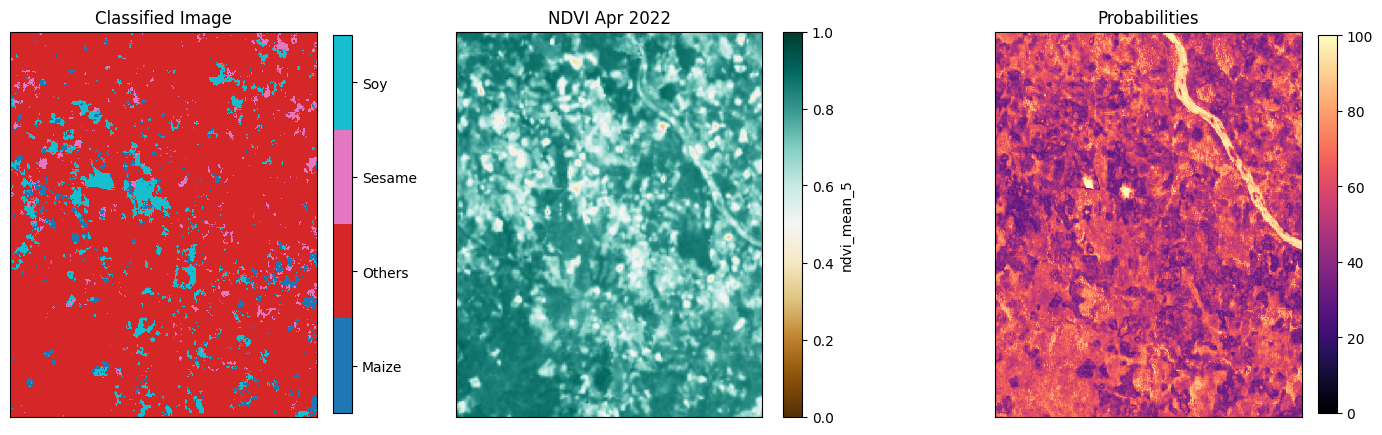

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# get discrete colormap
cmap = plt.get_cmap("tab10", len(labels_dict))
# set limits .5 outside true range
mat = (
    predicted.Predictions.astype(float).plot(
        ax=axes[0],
        cmap=cmap,
        vmin=-0.5,
        vmax=len(labels_dict)-0.5,
        add_labels=False,
        add_colorbar=False,
    )
)

# tell the colorbar to tick at integers
cax = plt.colorbar(
    mat,
    ticks=np.arange(min(labels_dict.values()),
                    max(labels_dict.values()) + 1),
    ax=axes[0],
    fraction=0.046,
    pad=0.04,
)
cax.ax.set_yticklabels(list(labels_dict.keys()))

# Plot NDVI
predicted["ndvi_mean_5"].plot(
    ax=axes[1], cmap="BrBG", vmin=0, vmax=1, add_colorbar=True)
axes[1].set_xlabel("")
axes[1].set_ylabel("")

predicted.Probabilities.plot(
    ax=axes[2],
    cmap="magma",
    vmin=0,
    vmax=100,
    add_labels=False,
    add_colorbar=True,
    cbar_kwargs={"fraction": 0.046, "pad": 0.04},
)

# Remove axes on all plots
for ax in axes:
    ax.set_aspect("equal")
    ax.tick_params(
        axis="both",
        which="both",
        top=False,
        bottom=False,
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
    )

# Add plot titles
axes[0].set_title("Classified Image")
axes[1].set_title("NDVI Apr 2022")
axes[2].set_title("Probabilities")


fig.savefig(os.path.join(output_folder, "crop_type_test_region.png"), dpi=300,
            bbox_inches="tight", facecolor="white")

## Close the dask client

In [13]:
client.close()

/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
